In [2]:
import numpy as np
import os
import pandas as pd
import math
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Initialized USER list

In [44]:
def Create_UserList(user_size):
    
    rows = [[i,"%.2f" %random.random(),"%.2f" %random.random(),"%.2f" %random.random(),"%.2f" %random.random()] for i in range(user_size)]
    df_user = pd.DataFrame(rows, columns=["user_ID","feature1", "feature2", "feature3", "feature4"])
    
    return df_user
#df_user = Create_UserList(100)

## Initialized ADs list

In [45]:
import random

def Create_AdList(Ad_size):
    
    rows = [[i, "%.2f" %random.uniform(90,100),0,0,0,0,0,0,0,0,[0],"%.2f" %random.random(),"%.2f" %random.random(),"%.2f" %random.random(),"%.2f" %random.random()] for i in range(Ad_size)]
    df_Ad = pd.DataFrame(rows, columns=["Ad_ID","TargetCpa","pCVR", "CVR","Imp","Conversion","Clk","GMV","ecpm","cost","Bias","feature1", "feature2", "feature3","feature4"])
    
    return df_Ad
#Create_AdList(100)

## Scrore function

In [46]:
# calculate epcm
def Ad_epcm(adjust_factor, pCVR,TargetCpa):
    epcm = adjust_factor * pCVR * TargetCpa
    return epcm

In [47]:
def Ad_Bias(gmv, cost, TargetCpa):
    bias = ((cost + 5*TargetCpa)/(gmv + 5*TargetCpa)) - 1
    return bias

In [48]:
def score(Ad_ID,user_ID,Ad_size):
    
    #产生一个随机数 x 转化率（暂时这么写）
    max_score = np.random.choice(Ad_size) * df_Ad['pCVR'][Ad_ID]
    return max_score

## Effect function

In [49]:
def effect(user_ID, Ad_ID):
    m = 1
    #random.randint(0,1)
    return m

In [50]:
def pmf(x,p):
    f = p**x*(1-p)**(1-x)
    return f

## Market Simulation

In [293]:
def Market_Simulation(request,Ad_size,user_size):
    
    #bias_list = []
    adjust_factor = 1.0
    #pCVR = 0.8
    
    df_lr = pd.DataFrame(columns=['feature1','feature2','feature3','cvr_process'])
    df_ecpm = pd.DataFrame(columns = ['Ad_ID','ecpm'])
    
    for k in range(request):
        #随机选出一个user
        user_ID = np.random.choice(user_size)
        
        #calculate pCVR and CVR
        LrCoef = 0.01
        
        #选出得分最大的Ad -- scoring 粗排
        for i in range(Ad_size):
            df_Ad.loc[i, ['CVR']] = (0.01+LrCoef * float(df_Ad["feature1"][i]) * float(df_user["feature1"][user_ID]) + LrCoef * float(df_Ad["feature2"][i])  * float(df_user["feature2"][user_ID]))
            df_Ad.loc[i, ['pCVR']] = float(df_Ad['CVR'][i])+0.01
            
            df_ecpm.loc[i,['Ad_ID']] = i
            df_ecpm.loc[i,['ecpm']] = Ad_epcm(adjust_factor,float(df_Ad['pCVR'][i]),float(df_Ad["TargetCpa"][i]))
            
        df_ecpm['ecpm'] = pd.to_numeric(df_ecpm['ecpm'], errors='coerce')
        df_scoring = df_ecpm.nlargest(n=Ad_size//10, columns=['ecpm'])
        ranking_ID_List = df_scoring['Ad_ID'].values.tolist()
        
        Max_Ad = 0
                
                
        #选出Ad -- reranking 精排
        for i in range(Ad_size):
            df_Ad.loc[i, ['CVR']] = (0.01+LrCoef * float(df_Ad["feature1"][i]) * float(df_user["feature1"][user_ID]) + LrCoef * float(df_Ad["feature2"][i])  * float(df_user["feature2"][user_ID])
                                     + LrCoef * float(df_Ad["feature3"][i])  * float(df_user["feature3"][user_ID]) + LrCoef * float(df_Ad["feature4"][i]) * float(df_user["feature4"][user_ID]))
            df_Ad.loc[i, ['pCVR']] = float(df_Ad['CVR'][i])+0.01
            
        for i in range(Ad_size//10):

            if (Ad_epcm(adjust_factor,float(df_Ad['pCVR'][ranking_ID_List[i]]),float(df_Ad["TargetCpa"][ranking_ID_List[i]]))>= 
                Ad_epcm(adjust_factor,float(df_Ad['pCVR'][ranking_ID_List[-1]]),float(df_Ad["TargetCpa"][ranking_ID_List[-1]]))):
                Max_Ad = ranking_ID_List[i]
                
                
                
                
                
        #m = effect(user_ID,Max_Ad)
        
        #conv=0 or 1
        conv = np.random.binomial(n = 1,p = float(df_Ad["pCVR"][Max_Ad]),size  = None) 
        
        #total_conv+=conv 
        df_Ad.loc[Max_Ad, ['Conversion']] += conv
        
        #total_gmv+=conv*TargetCPA
        df_Ad.loc[Max_Ad, ['GMV']] += conv * float(df_Ad["TargetCpa"][Max_Ad] )
        
        #total_cost+=ecpm
        df_Ad.loc[Max_Ad, ['cost']] += Ad_epcm(adjust_factor,float(df_Ad['pCVR'][Max_Ad]),float(df_Ad["TargetCpa"][Max_Ad]))
        
        
        kp = 0.5
        ki = 0.1
        kd = 0.2
        
        # current bias
        Bias_M = Ad_Bias(float(df_Ad["GMV"][Max_Ad]), float(df_Ad["cost"][Max_Ad]), float(df_Ad["TargetCpa"][Max_Ad]))
        
        # record all the bias_m in the list
        df_Ad["Bias"][Max_Ad].append(Bias_M)
       
        # calculate PID
        if len(df_Ad["Bias"][Max_Ad]) > 2:
            PID = kp * float(df_Ad["Bias"][Max_Ad][-1]) + ki * sum(df_Ad["Bias"][Max_Ad]) + kd * (float(df_Ad["Bias"][Max_Ad][-1]) - float(df_Ad["Bias"][Max_Ad][-2]))
        else:
            PID = kp * float(df_Ad["Bias"][Max_Ad][-1]) + ki * sum(df_Ad["Bias"][Max_Ad]) + 0
        
        adjust_factor = 1/(1+PID)
        
        
        ## update all pCVR
        #create dataframe, append corresponding users, ads features and CVR to the dataframe. x1, x2, x3, x4, and y(CVR)
        
        
        if (k+1) % (request/10) == 0: #already reach to every 1/10 request
            
            # fit LR model 
            reg = LinearRegression().fit(df_lr.drop(['cvr_process'], axis = 1), df_lr.cvr_process)
            
            #update all Ad pCVR
            for i in range(Ad_size):
                df_Ad.loc[i,['pCVR']] = (reg.intercept_ + reg.coef_[0] * float(df_Ad["feature1"][i]) * float(df_user["feature1"][user_ID]) + reg.coef_[1] * float(df_Ad["feature2"][i])  * float(df_user["feature2"][user_ID]) 
                                         + reg.coef_[2] * float(df_Ad["feature3"][i])  * float(df_user["feature3"][user_ID])) 
            
            #clear df_lr, create a new one for next 1/10 request 
            df_lr = df_lr.iloc[0:0]
            
        
        else:
            df_lr.loc[k] = [float(df_Ad["feature1"][Max_Ad]) * float(df_user["feature1"][user_ID]), float(df_Ad["feature2"][Max_Ad]) * float(df_user["feature2"][user_ID]), 
                            float(df_Ad["feature3"][Max_Ad]) * float(df_user["feature3"][user_ID]), df_Ad["pCVR"][Max_Ad]]
            
        
        
        
        #total_imp+=1
        df_Ad.loc[Max_Ad,['Imp']] = df_Ad["Imp"][Max_Ad]+1
        
    return df_Ad

In [312]:

request = 50000
user_size = 5000
Ad_size = 500

df_user=Create_UserList(user_size)
df_Ad=Create_AdList(Ad_size)
#print(len(df_Ad["Bias"][2]))
df_Ad

,Ad_ID,TargetCpa,pCVR,CVR,Imp,Conversion,Clk,GMV,ecpm,cost,Bias,feature1,feature2,feature3,feature4
0,0,93.78,0,0,0,0,0,0,0,0,[0],0.36,0.61,0.80,0.33
1,1,99.73,0,0,0,0,0,0,0,0,[0],0.44,0.88,0.75,0.81
2,2,94.86,0,0,0,0,0,0,0,0,[0],0.52,0.73,0.52,0.14
3,3,99.38,0,0,0,0,0,0,0,0,[0],0.67,0.31,0.36,0.93
4,4,92.84,0,0,0,0,0,0,0,0,[0],0.47,0.33,0.31,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,98.98,0,0,0,0,0,0,0,0,[0],0.04,0.92,0.22,0.43
496,496,92.75,0,0,0,0,0,0,0,0,[0],0.88,0.92,0.39,0.05
497,497,93.40,0,0,0,0,0,0,0,0,[0],0.25,0.44,0.21,0.52
498,498,96.42,0,0,0,0,0,0,0,0,[0],0.63,0.26,0.75,0.98


In [313]:
%%time
Market_Simulation(request,Ad_size,user_size)

CPU times: user 1d 16h 37min 51s, sys: 1h 22min 52s, total: 1d 18h 44s
Wall time: 1d 17h 5min 35s


,Ad_ID,TargetCpa,pCVR,CVR,Imp,Conversion,Clk,GMV,ecpm,cost,Bias,feature1,feature2,feature3,feature4
0,0,93.78,0.029471,0.016832,0,0,0,0.00,0,0.000000,[0],0.36,0.61,0.80,0.33
1,1,99.73,0.030175,0.017834,264,12,0,1196.76,0,1371.107832,"[0, 0.007669940395699237, 0.015421358122892581...",0.44,0.88,0.75,0.81
2,2,94.86,0.029372,0.016598,0,0,0,0.00,0,0.000000,[0],0.52,0.73,0.52,0.14
3,3,99.38,0.028796,0.016452,34,0,0,0.00,0,55.329985,"[0, 0.00613194969745634, 0.011829680465900827,...",0.67,0.31,0.36,0.93
4,4,92.84,0.027490,0.014812,0,0,0,0.00,0,0.000000,[0],0.47,0.33,0.31,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,98.98,0.025708,0.013106,82,2,0,197.96,0,189.811365,"[0, 0.006380993580209049, 0.010732654519993945...",0.04,0.92,0.22,0.43
496,496,92.75,0.031168,0.018330,334,9,0,834.75,0,1080.792715,"[0, 0.005467992122375254, 0.010377174504666575...",0.88,0.92,0.39,0.05
497,497,93.40,0.026012,0.013428,0,0,0,0.00,0,0.000000,[0],0.25,0.44,0.21,0.52
498,498,96.42,0.030166,0.017884,0,0,0,0.00,0,0.000000,[0],0.63,0.26,0.75,0.98


In [337]:
df_graph = pd.DataFrame(columns = ['id','cost'])

df_Ad['cost'] = pd.to_numeric(df_Ad['cost'], errors='coerce')
df_2 = df_Ad.nlargest(n=495, columns=['cost'])
id = [[i] for i in range(495)]
df_2['id'] = id
df_2
#ranking_ID_List = df_scoring['Ad_ID'].values.tolist()

,Ad_ID,TargetCpa,pCVR,CVR,Imp,Conversion,Clk,GMV,ecpm,cost,Bias,feature1,feature2,feature3,feature4,id
362,362,93.00,0.029449,0.016690,274,6,0,558.00,0,22023.345365,"[0, 0.00701889483602991, 0.014341738154586947,...",0.78,0.85,0.15,0.22,[0]
133,133,95.05,0.029522,0.016888,205,6,0,570.30,0,12106.324715,"[0, 0.005585666056512784, 0.011855938655993992...",0.88,0.37,0.23,0.47,[1]
244,244,94.76,0.030741,0.018416,1586,51,0,4832.76,0,7895.223100,"[0, 0.006988208514216998, 0.013678246337142097...",0.70,0.86,0.55,0.88,[2]
25,25,97.01,0.032529,0.020026,1768,51,0,4947.51,0,6878.838434,"[0, 0.006795788334555297, 0.013141249612075523...",0.75,0.71,0.96,0.54,[3]
66,66,97.81,0.031997,0.019310,548,23,0,2249.63,0,6506.023539,"[0, 0.007674892675288758, 0.015644505744313753...",0.60,0.84,0.98,0.21,[4]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,97.83,0.028374,0.015740,150,4,0,391.32,0,-1696.077406,"[0, -0.18340161800418442, -0.19970261694198654...",0.49,0.03,0.61,0.43,[490]
255,255,97.99,0.027241,0.014592,162,3,0,293.97,0,-1703.569359,"[0, -0.011063543626191663, -0.0134992712615453...",0.14,0.04,0.80,0.36,[491]
434,434,94.12,0.027030,0.014264,547,14,0,1317.68,0,-2269.042593,"[0, -0.019536282700929775, -0.0332249046696278...",0.14,0.34,0.63,0.16,[492]
246,246,95.30,0.026345,0.013974,804,26,0,2477.80,0,-3358.865137,"[0, -0.010334662977346865, -0.0213695310277545...",0.27,0.17,0.37,0.88,[493]


<AxesSubplot:xlabel='id'>

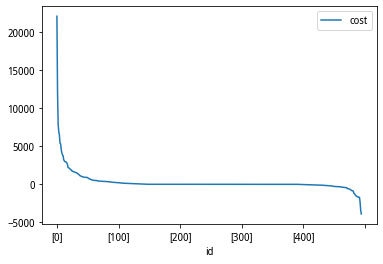

In [338]:
df_2.plot(x ='id', y='cost', kind = 'line')

## Test code

In [273]:
request = 10000
user_size = 1000
Ad_size = 100

df_user=Create_UserList(user_size)
df_Ad=Create_AdList(Ad_size)
#print(len(df_Ad["Bias"][2]))
df_Ad

,Ad_ID,TargetCpa,pCVR,CVR,Imp,Conversion,Clk,GMV,ecpm,cost,Bias,feature1,feature2,feature3,feature4
0,0,95.78,0,0,0,0,0,0,0,0,[0],0.12,0.36,0.79,0.67
1,1,96.92,0,0,0,0,0,0,0,0,[0],0.58,0.10,0.31,0.99
2,2,99.77,0,0,0,0,0,0,0,0,[0],0.29,0.67,0.54,0.17
3,3,93.17,0,0,0,0,0,0,0,0,[0],0.11,0.74,0.83,0.82
4,4,90.22,0,0,0,0,0,0,0,0,[0],0.27,0.11,0.41,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,96.65,0,0,0,0,0,0,0,0,[0],0.45,0.50,0.19,0.05
96,96,94.18,0,0,0,0,0,0,0,0,[0],0.65,0.28,0.06,0.86
97,97,99.65,0,0,0,0,0,0,0,0,[0],0.69,0.08,0.01,0.14
98,98,93.23,0,0,0,0,0,0,0,0,[0],0.02,0.35,0.90,0.90


In [285]:
user_ID = np.random.choice(user_size)
df_ecpm = pd.DataFrame(columns = ['Ad_ID','ecpm'])       
#calculate pCVR and CVR
LrCoef = 0.01
for i in range(Ad_size):
    df_Ad.loc[i, ['CVR']] = (0.01+LrCoef * float(df_Ad["feature1"][i]) * float(df_user["feature1"][user_ID]) + LrCoef * float(df_Ad["feature2"][i])  * float(df_user["feature2"][user_ID]))
    df_Ad.loc[i, ['pCVR']] = float(df_Ad['CVR'][i])+0.01

    df_ecpm.loc[i,['Ad_ID']] = i
    df_ecpm.loc[i,['ecpm']] = Ad_epcm(adjust_factor,float(df_Ad['pCVR'][i]),float(df_Ad["TargetCpa"][i]))

df_ecpm['ecpm'] = pd.to_numeric(df_ecpm['ecpm'], errors='coerce')
df_scoring = df_ecpm.nlargest(n=Ad_size//10, columns=['ecpm'])
ranking_ID_List = df_scoring['Ad_ID'].values.tolist()
print(ranking_ID_List)

[79, 66, 33, 99, 70, 32, 75, 40, 54, 60]


In [287]:
for i in range(Ad_size):
        df_Ad.loc[i, ['CVR']] = (0.01+LrCoef * float(df_Ad["feature1"][i]) * float(df_user["feature1"][user_ID]) + LrCoef * float(df_Ad["feature2"][i])  * float(df_user["feature2"][user_ID])
                                 + LrCoef * float(df_Ad["feature3"][i])  * float(df_user["feature3"][user_ID]) + LrCoef * float(df_Ad["feature4"][i]) * float(df_user["feature4"][user_ID]))
        df_Ad.loc[i, ['pCVR']] = float(df_Ad['CVR'][i])+0.01

In [291]:
for i in range(10):
    print(df_Ad['pCVR'][ranking_ID_List[i]])
    print(df_Ad["TargetCpa"][ranking_ID_List[i]])

0.026813000000000003
99.74
0.024217000000000002
99.01
0.024073999999999998
99.33
0.024707
96.88
0.024502000000000003
99.69
0.026088
98.23
0.024486
98.64
0.025069
93.07
0.025287999999999998
99.47
0.024870999999999997
99.70


In [292]:
for i in range(Ad_size//10):
    if (Ad_epcm(adjust_factor,float(df_Ad['pCVR'][ranking_ID_List[i]]),float(df_Ad["TargetCpa"][ranking_ID_List[i]]))>= Ad_epcm(adjust_factor,float(df_Ad['pCVR'][ranking_ID_List[i-1]]),float(df_Ad["TargetCpa"][ranking_ID_List[i-1]]))):
        Max_Ad = ranking_ID_List[i]
print(Max_Ad)

54
